In [2]:
import sys
import warnings
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.result import marginal_counts
from qiskit.providers.ibmq.job import job_monitor
from qiskit.tools.visualization import plot_histogram
import qiskit.quantum_info as qi
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [3]:
%matplotlib inline
!pip install --quiet noisyopt
!pip install --quiet numba --upgrade --user
!pip install --quiet pennylane-sf --upgrade
from noisyopt import minimizeSPSA
import numpy as np
import itertools

(0) Load the dataset and process it likewise the classical method
======================

In [4]:
import classical

In [5]:
x_train, y_train, x_val, y_val, x_test, y_test = \
    classical.get_data()

Loading stocks


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 199.34it/s]


Preprocessing Data
Done


(1) First consider the case with only 1 feature (closed price). Normalize our feature x_1. 
======================
Our current data encoding method (from a floating point number to an angle), requires the floating number between (0,1]. So we need to first process the data using min-max normalization (like what we did to the volumn)


(2) Encode the normalized feature into an angle
======================

$$x_i` = \sqrt{(1-x_i^2)}$$
$$ angle \space \phi = \arctan{(x`_i/x_i)}$$

In [6]:
def get_open_only(x_data):
    return [x_datapoint[:, 0] for x_datapoint in x_data]
x_train = get_open_only(x_train)
x_val = get_open_only(x_val)
x_test = get_open_only(x_test)

In [7]:
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

In [8]:
def float_to_angle(x):
    x = sigmoid(x) # send to 0-1
    x_pi = np.sqrt(1-np.square(x))
    return np.arctan(x_pi/(x + 1e-5))

train_angles = np.array([float_to_angle(x) for x in x_train])
test_angles = np.array([float_to_angle(x) for x in x_test])    

val_angles = np.array([float_to_angle(x) for x in x_val])

train_angles_y = np.array([float_to_angle(y) for y in y_train])
test_angles_y = np.array([float_to_angle(y) for y in y_test])
val_angles_y = np.array([float_to_angle(y) for y in y_val])
assert np.all(0 <= train_angles)
assert np.all(train_angles <= np.pi)

(3) Input the angle into Displacement gate
===========================
Input the angle into Displacement gate, to eventually integrate our features to the circuit. \
Reference of the Displacement gate: https://docs.pennylane.ai/en/stable/code/api/pennylane.Displacement.html \
Our current circuit is the one in "Rapid training of QRNN". Displacement gate is the D gate in the following figure. \
The I gate in the figure has been modeled by Luis into combination of basis gates (which can be found in the APIs in Pennylane). So we can first implement the circuit. Because Pennylane and Xanadu are proposed by the same company, we think that it will be smooth to run the code on Xanadu, after running on LocalSimulator.

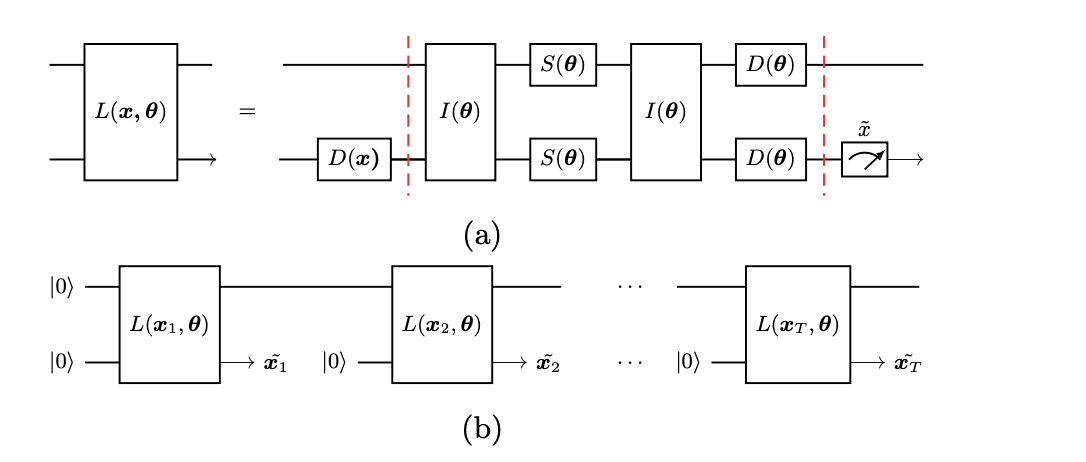

Variational classifiers usually define a "layer" or "block", which is an
elementary circuit architecture that gets repeated to build the
variational circuit.

Our circuit layer consists of an arbitrary rotation on every qubit, as
well as CNOTs that entangle each qubit with its neighbour.


In [33]:
depth = 1
q_wires = 2
combs = itertools.combinations(range(q_wires), 2)

def vqc_unit(params,qc,theta):

    # Encoding
    qc.u(theta[0][0],0,0,1)
    qc.barrier()
    # Interaction
    for m in range(depth + 1):
        for i in range(q_wires):
            circuit.u(params[m, i, 0], params[m, i, 1], params[m, i, 2],i)
        if m != depth:
            circuit.cx(1,0)

def circuit_vqc(weights,circuit,theta):
    
    vqc_unit(weights,circuit,theta)
    

In [14]:
np.random.seed(0)
num_qubits = 2
num_layers = 1
n_wires = 2
weights_init_qaoa = 2 * np.pi * np.random.randn(depth + 1, n_wires, 3)
print(weights_init_qaoa)

[[[11.08386778  2.51426189  6.14959212]
  [14.07994722 11.73421292 -6.14041802]]

 [[ 5.96958159 -0.95100539 -0.64854317]
  [ 2.57986647  0.90505245  9.13746993]]]


In [36]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = np.mean(loss)
    return loss

In [38]:
# https://pennylane.ai/qml/demos/spsa.html
costs = []
circuit = QuantumCircuit(q_wires,2)
backend = Aer.get_backend('aer_simulator')
shots = 1000


def cost_spsa(weights):
    batch_inds = [np.random.randint(train_angles.shape[0], size=1)]

    X = train_angles[batch_inds, 0:1]
    weights = weights.reshape(weights_init_qaoa.shape)
    predictions = []
    i=0
    for x in X:
        circuit_vqc(weights,circuit,x)

        if i<X.shape[0]-1:
            circuit.reset([1])
            i+=1
            
    circuit.measure([1], [0])
    simp_job = execute(circuit, backend=backend,shots=shots)
    simp_counts0 = marginal_counts(simp_job.result(),indices=[0]).get_counts()
    predictions.append(max(simp_counts0['0'],simp_counts0['1'])/shots)
    #print(predictions)

    return square_loss(train_angles_y[batch_inds, 0:1], predictions)

x0=weights_init_qaoa.flatten().copy()
test = cost_spsa(x0)
test
# iteration_num = 0
# init_exe_count = int(dev_IonQ.num_executions)
# def callback_fn(w):
#     global iteration_num
#     num_executions = int(backend.num_executions) - init_exe_count

#     iteration_num += 1
#     if iteration_num % 10 == 0:
#         cost_val = cost_spsa(w)
#         costs.append(cost_val)

#         print(
#             f"Iteration = {iteration_num}, "
#             f"Number of device executions = {num_executions}, "
#             f"Cost = {cost_val}"
#         )
        
# init_w = weights_init_qaoa if use_qaoa else weights_init
# res = minimizeSPSA(
#     cost_spsa,
#     x0=init_w.flatten().copy(),
#     niter=200,
#     paired=False,
#     c=0.02,
#     a=0.1,
#     callback=callback_fn,
# )

0.008383344

end
==============